In [1]:
### Defining Environment variables pointing to user folders
from os import environ
from glob import glob

environ.setdefault('DATA_STORAGE',"/mlinfn/minio/lhcb-data/anderlinil/LamarrBenderTrain")

environ.setdefault('HOME_DIR', "/mlinfn/shared/lamarr/"+ environ['USERNAME'])
environ.setdefault('TRAINING_DATA_FOLDER',"/2016MU/10134000")
environ.setdefault('MODEL_STORAGE',environ['HOME_DIR']+"/trained_models"+environ['TRAINING_DATA_FOLDER'])

environ.setdefault('INPUT_PATH',environ['DATA_STORAGE']+environ['TRAINING_DATA_FOLDER']+"/*.root")
environ.setdefault('INPUT_FILES'," ".join(glob(environ['INPUT_PATH'])))

environ.setdefault("FEATHER_FOLDER"       , environ['HOME_DIR']+"/lb-trksim-train/notebooks/feather_folder"+environ['TRAINING_DATA_FOLDER'])
environ.setdefault("RESOLUTION_TRAIN"     , environ["FEATHER_FOLDER"]+"/resolution-train")
environ.setdefault("RESOLUTION_TEST"      , environ["FEATHER_FOLDER"]+"/resolution-test")
environ.setdefault("RESOLUTION_VALIDATION", environ["FEATHER_FOLDER"]+"/resolution-validation")
environ.setdefault("COVARIANCE_TRAIN"     , environ["FEATHER_FOLDER"]+"/covariance-train")
environ.setdefault("COVARIANCE_TEST"      , environ["FEATHER_FOLDER"]+"/covariance-test")
environ.setdefault("COVARIANCE_VALIDATION", environ["FEATHER_FOLDER"]+"/covariance-validation")

_ = environ.setdefault('NB_EXPORT',"True")

# Preprocessing steps for *Resolution* and *Covariance* models
##### Tested on environment `LHCb Analysis Facility` of Docker image `landerli/lhcbaf:v0p8`

This notebook loads, prepares and caches the data for the training of the resolution and covariance models.
Both resolution and covariance rely on GANs and benefit from larger statistics if compared to acceptance and efficiency models.
Nonetheless, the preprocessing procedure is similar: data are loaded from the remote storage and coverted from ROOT to pandas DataFrames, then a `QuantileTransformer` is applied. 

In addition, we will introduce a custom `DecorrTransformer` that decorrelate features by covariance matrix diagionalization. This step is particularly important for modeling the covariance because of the strong correlation arising between different element of the covariance matrix. While strong correlation is usually manageable by Neural Networks, here the correlated features are part of the reference dataset that the generator should learn reproducing by minimizing some measure of the distance between distributions. 
In the original forumulation of GANs, that we are using here with minor tweaks, the measure of the distance between the generated and reference distribution saturates when the two distributions are disjoint. Strong correlation between variables makes it more difficult to avoid disjoint distributions and causes less predictable training outcome. 

## Technologies and libraries
On top of the standard Python echosystem we are using:
 * `uproot` to convert data from ROOT TTrees to `pandas DataFrames`
 * dask DataFrame to enable processing datasets larger than the available RAM (Out-of-memory computation). 
 * `Arrow Featether` data format to cache in local storage the training dataset
     * refer to [`feather_io.py`](./feather_io.py) for a custom wrapper to Feather

In [2]:
import numpy as np
import pandas as pd 
import dask.dataframe as ddf
import uproot
from os import environ

/envs/root/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Loading data
Input data are obtained from the environment variable `$INPUT_FILES`.
For debugging purpose a default value is provided.

In [3]:
from glob import glob
file_pattern = "/mlinfn/minio/lhcb-data/anderlinil/LamarrBenderTrain/j100/*.root" # default path
default_file_path = environ.get("INPUT_PATH", file_pattern)
file_list = environ.get("INPUT_FILES", " ".join(glob(default_file_path))).split(" ")

print (f"Found {len(file_list)} files from {default_file_path}")  

Found 194 files from /mlinfn/minio/lhcb-data/anderlinil/LamarrBenderTrain/2016MU/10134000/*.root


### Conversion from `ROOT TTree` to `Pandas DataFrame`

Training data is obtained from a Bender job running on simulated data.
The ROOT files obtained from Bender are structured in multiple `TDirector`ies for the training of different models.
Here we are considering only the *Tracking* part, corresponding to the `TDirectory` named `"TrackingTuple"`.

Two `TTree`s are defined:
 * `sim` with the generator-level particles, possibly matched to reconstructed tracks
 * `reco` reconstructed tracks with additional information on the reconstructed track parameters and their uncertainties.



In [4]:
def read_root(filename, tree=None):
    if tree is None:
        return uproot.open(filename)
    
    return pd.DataFrame(uproot.open(filename)[tree].arrays(library='np'))

from functools import partial
reco = (ddf
        .from_map (partial(read_root, tree="TrackingTupler/reco"), file_list)
        .query("(type == 3) or (type == 4) or (type == 5)")
       )

### `reco`: reconstructed particles

The complete list of variables defined for particles passing the reconstruction step is shown below.

In [5]:
n_rows = len(reco.columns)//4
print ("\n".join([" ".join([f"{c:24s}" for c in reco.columns[i::n_rows]]) for i in range(n_rows)]))

mc_key                   true_mass_ClosestToBeam  cov_BegRich1_0_1         cov_AtT_1_3              cov_EndRich2_3_4        
evtNumber                x_ClosestToBeam          cov_BegRich1_1_1         cov_AtT_2_3              cov_EndRich2_4_4        
runNumber                y_ClosestToBeam          cov_BegRich1_0_2         cov_AtT_3_3             
PID                      z_ClosestToBeam          cov_BegRich1_1_2         cov_AtT_0_4             
clone                    qop_ClosestToBeam        cov_BegRich1_2_2         cov_AtT_1_4             
purity                   cov_ClosestToBeam_0_0    cov_BegRich1_0_3         cov_AtT_2_4             
type                     cov_ClosestToBeam_0_1    cov_BegRich1_1_3         cov_AtT_3_4             
history                  cov_ClosestToBeam_1_1    cov_BegRich1_2_3         cov_AtT_4_4             
fitHistory               cov_ClosestToBeam_0_2    cov_BegRich1_3_3         px_BegRich2             
ghostProb                cov_ClosestToBeam_1_2    

# Resolution model

For consistency with the acceptance and efficiency models, we are defining:
 * `mc_log10_p` as $\log_{10}(p)$, which ease the job to the Quantile transformer;
 * `is_e`, `is_mu` and `is_h` providing boolean values used to define whether a particle is an electron, a muon or a hadron (pion, kaon or proton);
 * `nDoF_f` obtained by adding a random number, uniformly distributed in the range $[0, 1]$ to the number of degrees of freedom of the track fit.

In addition we are defining:
 * the boolean flags `long`, `upstream` and `downstream` which encode the particle type in one-hot-encoded classes
 * `dx`, `dy`, `dz`, `dtx`, `dty` and `dp` representing the difference between the reconstructed and generator-level quantity of the position ($x$, $y$, and $z$), the slope ($t_x$ and $t_y$) and the momentum ($p$), as evaluated in the `ClosestToBeam` track state.

In [6]:
reco['mc_log10_p'] = np.log10(reco.mc_p)
reco['mc_is_e'] = abs(reco.PID).isin([11]).astype(np.float32)
reco['mc_is_mu'] = abs(reco.PID).isin([13]).astype(np.float32)
reco['mc_is_h'] = abs(reco.PID).isin([211, 321, 2212]).astype(np.float32)
reco['long'] = (reco.type==3).astype(np.float32)
reco['upstream'] = (reco.type==4).astype(np.float32)
reco['downstream'] = (reco.type==5).astype(np.float32)
reco['dx'] = reco.x_ClosestToBeam - reco.true_x_ClosestToBeam
reco['dy'] = reco.y_ClosestToBeam - reco.true_y_ClosestToBeam
reco['dz'] = reco.z_ClosestToBeam - reco.true_z_ClosestToBeam
reco['dtx'] = reco.tx_ClosestToBeam - reco.true_tx_ClosestToBeam
reco['dty'] = reco.ty_ClosestToBeam - reco.true_ty_ClosestToBeam
reco['dp'] = reco.reco_p - reco.mc_p
reco = reco.map_partitions(lambda df: df.assign(nDoF_f = df.nDoF + np.random.uniform(0, 1, len(df))))

### Features

The resolution model takes as inputs the generator-level position, slope and momentum of the particle in where its trajectory minimizes the distance from the $z$ axis (`ClosestToBeam`), three boolean flags representing the nature of the particle (electron, muon or hadron) and three boolean flags representing the track category as defined by the efficiency model.

The resolution model should provide as an output the difference between the reconstructed values and the input feature, plus track-quality metrics such as the number of degrees of freedom and the $\chi^2$ of the track fit, and the ghost probability.

Clearly, in the training sample these quantities are obtained with reconstruction algorithms performing the track fit. In Lamarr, these parameters will be generated randomly trying to reproduce the distributions observed in the training dataset.


In [7]:
res_real_conditions = [
    'true_x_ClosestToBeam', 'true_y_ClosestToBeam', 'true_z_ClosestToBeam', 
    'true_tx_ClosestToBeam', 'true_ty_ClosestToBeam', 'mc_log10_p'
]

res_flags = ['mc_is_e', 'mc_is_mu', 'mc_is_h', 'long', 'upstream', 'downstream']

res_conditions = res_real_conditions + res_flags
res_target = ['dx', 'dy', 'dz', 'dtx', 'dty', 'dp', 'chi2PerDoF', 'nDoF_f', 'ghostProb']

from IPython.display import HTML
def list_vars(title, var_list):
    display(HTML (f"<P><B>{title}</B><UL>" + "\n".join(f"<LI> <PRE>{var}</PRE> " for var in var_list) + "</UL><HR>"))

list_vars("Input features (real)", res_real_conditions)
list_vars("Input features (boolean)", res_flags)
list_vars("Output features (real)", res_target)

### Some statistics
We report below some basic statistics on the dataset defined to train the resolution model.
These plots might highlight pathological contributions to the distributions, such as error values resulting in large spikes or outliers  inconsistent with the core of the distribution.

#### Some rows 
Only a fraction of the whole dataset is used for this study and then for defining the preprocessing step.

In [8]:
df = reco[res_conditions + res_target].head(300_000, npartitions=10)
display(HTML(f"The number of rows used in this notebook is {len(df)}"))
df

,true_x_ClosestToBeam,true_y_ClosestToBeam,true_z_ClosestToBeam,true_tx_ClosestToBeam,true_ty_ClosestToBeam,mc_log10_p,mc_is_e,mc_is_mu,mc_is_h,long,...,downstream,dx,dy,dz,dtx,dty,dp,chi2PerDoF,nDoF_f,ghostProb
4,0.490365,-0.477634,7.548103,0.076353,0.078388,3.903246,0.0,0.0,1.0,1.0,...,0.0,-0.039365,0.001734,-0.534503,0.000036,-0.000573,35.630371,1.010721,35.225800,0.002876
5,0.560771,0.216658,17.590837,-0.027688,0.071665,3.567113,1.0,0.0,0.0,1.0,...,0.0,0.048729,-0.046258,1.441362,-0.000567,0.000933,-4.984375,1.200072,37.308065,0.011449
7,0.595299,-0.428453,15.470662,-0.036398,-0.050572,3.825427,0.0,0.0,1.0,1.0,...,0.0,-0.082999,0.072653,-0.890262,0.000743,-0.000080,35.061523,0.642418,29.766196,0.004388
8,-0.736912,5.212535,226.350449,0.087482,0.012368,3.395407,0.0,0.0,1.0,1.0,...,0.0,-0.159888,-0.236236,-2.436447,-0.000112,0.001636,21.905762,0.589242,31.195186,0.004228
9,0.415492,0.288020,2.268929,0.038918,-0.056142,3.999995,0.0,0.0,1.0,1.0,...,0.0,-0.002792,0.059280,-0.680029,-0.000287,-0.000029,-54.550781,1.088388,36.869881,0.003459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23646,0.910908,0.221235,6.318191,0.008962,-0.036900,4.577016,0.0,0.0,1.0,1.0,...,0.0,0.045392,-0.008935,1.450709,-0.000132,-0.000223,139.226562,0.827334,32.236720,0.003259
23647,1.074273,0.096656,7.153558,0.002997,-0.033312,4.407469,0.0,0.0,1.0,1.0,...,0.0,-0.046574,-0.000356,0.147642,0.000193,-0.000090,115.357422,1.066410,32.488613,0.004132
23648,0.068832,0.162245,21.843660,-0.085453,0.036253,3.929921,1.0,0.0,0.0,1.0,...,0.0,-0.050032,0.003455,0.512539,-0.000001,0.000025,-1141.478027,0.839126,35.381099,0.003787
23653,0.626500,0.266221,30.125322,0.078044,-0.183661,3.675940,0.0,0.0,1.0,1.0,...,0.0,-0.026800,-0.028621,0.021378,0.000379,0.000343,32.105469,2.079171,27.306953,0.098527


#### Track class representation per particle type

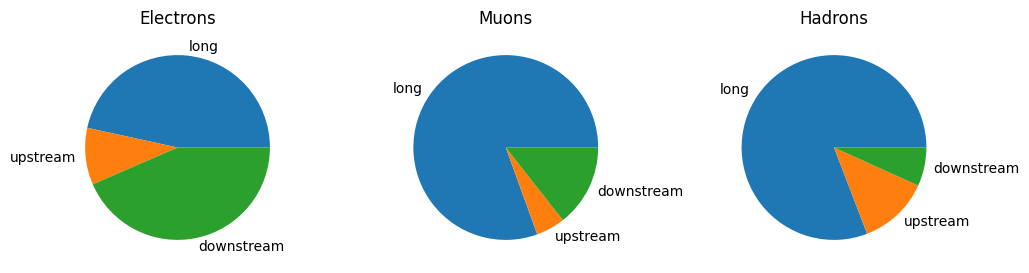

In [9]:
import matplotlib.pyplot as plt

classes = "long", "upstream", "downstream"
plt.figure(figsize=(12,3))
for iPlot, part in enumerate(('e', 'mu', 'h'), 1):
    plt.subplot(1,3,iPlot)
    pdf = df.query(f'mc_is_{part}==1')
    counts = [np.count_nonzero(pdf[c]) for c in classes]
    plt.pie(counts, labels=classes)
    plt.title(dict(e='Electrons', mu="Muons", h="Hadrons")[part])



#### Resolution function per particle type

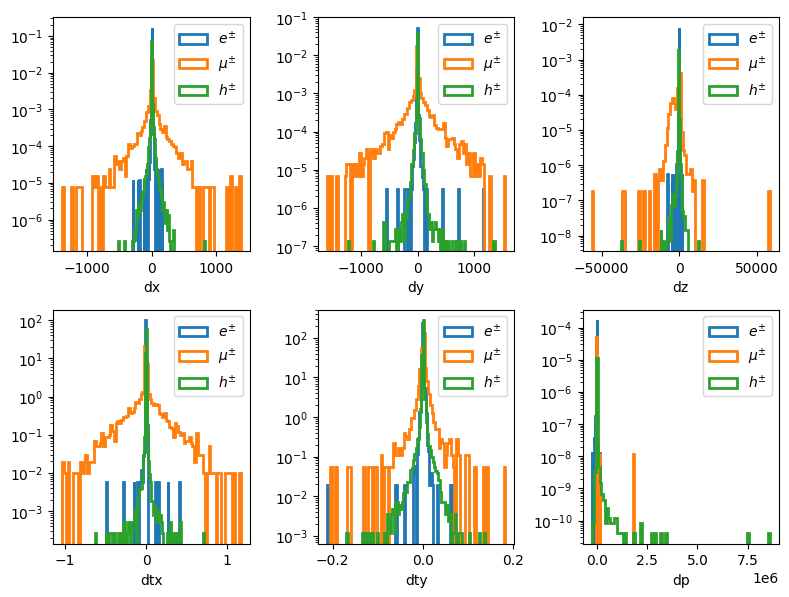

In [10]:
pure_res_vars = res_target[:6]

plt.figure(figsize=(8,6))
for iPlot, var in enumerate(pure_res_vars, 1):
    for part in ('e', 'mu', 'h'):
        plt.subplot(2,3,iPlot)
        label=dict(e='$e^{\pm}$', mu="$\mu^{\pm}$", h="$h^{\pm}$")[part]
        plt.hist(df.query(f'mc_is_{part}==1')[var], bins=100, label=label, histtype='step', linewidth=2, density=True)
        plt.xlabel(var)
        plt.yscale('log')
        plt.legend()

plt.tight_layout()
plt.show()


#### Track-quality metrics per particle type

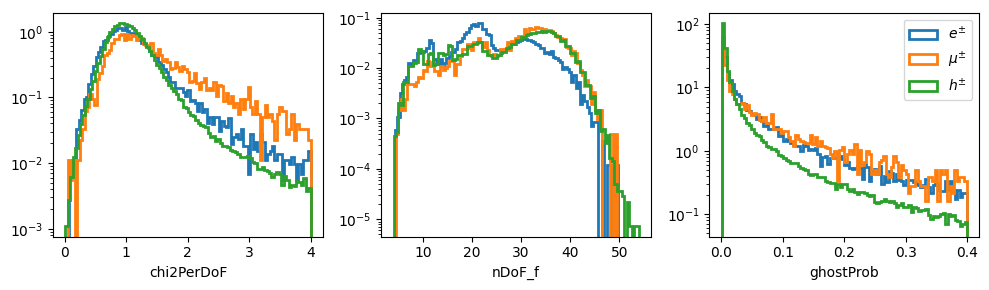

In [11]:
track_quality = res_target[6:]

plt.figure(figsize=(10,3))
for iPlot, var in enumerate(track_quality, 1):
    for part in ('e', 'mu', 'h'):
        plt.subplot(1,3,iPlot)
        label=dict(e='$e^{\pm}$', mu="$\mu^{\pm}$", h="$h^{\pm}$")[part]
        plt.hist(df.query(f'mc_is_{part}==1')[var], bins=100, label=label, histtype='step', linewidth=2, density=True)
        plt.xlabel(var)
        plt.yscale('log')
        if iPlot==3: plt.legend()

plt.tight_layout()
plt.show()


#### Resolution function per particle type

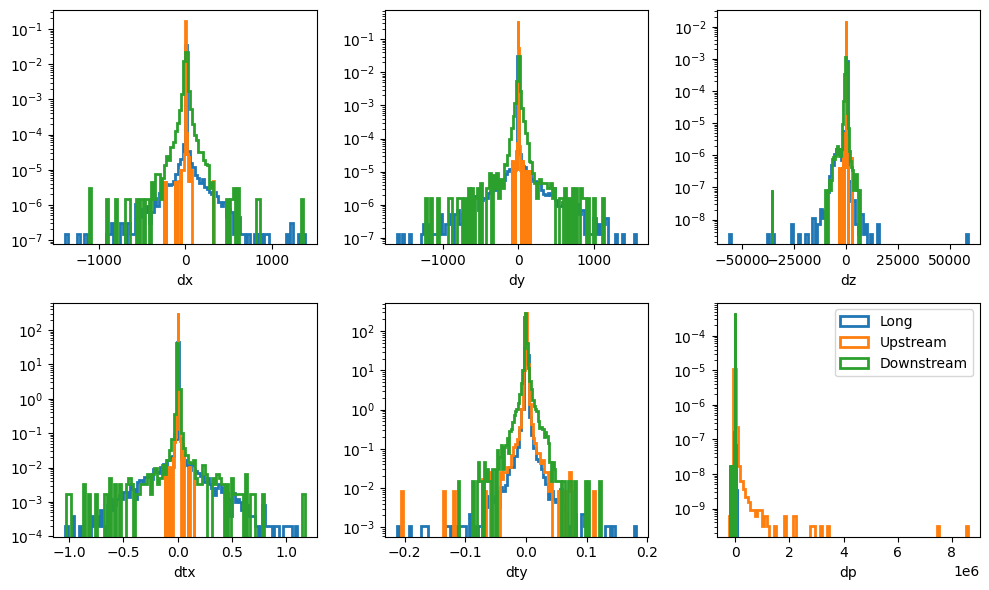

In [12]:
pure_res_vars = res_target[:6]

plt.figure(figsize=(10,6))
for iPlot, var in enumerate(pure_res_vars, 1):
    for track_type in ('long', 'upstream', 'downstream'):
        plt.subplot(2,3,iPlot)
        label=track_type.capitalize()
        plt.hist(df.query(f'{track_type}==1')[var], bins=100, label=label, histtype='step', linewidth=2, density=True)
        plt.xlabel(var)
        plt.yscale('log')
        if iPlot==6: plt.legend()

plt.tight_layout()
plt.show()


## Preprocessing  (*resolution model*)

We are using the `ColumnTransformer` class from *scikit-learn* to apply different preprocessing to the real and boolean features. 
Boolean features are passed through as they are, while a `QuantumTransformer` (once again from *scikit-learn*) is used to transform the real quantities in gaussian-distributed features.

As a difference with acceptance and efficiency models, for GAN-models the preprocessing of the output features is also critical.
As all of the output features are real features, we transform everything with a `QuantileTransformer`.


In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import QuantileTransformer

n_features = len(res_real_conditions)
n_flags = len(res_flags)
n_target = len(res_target)

tX = ColumnTransformer([
    ('features', QuantileTransformer(output_distribution='normal'), np.arange(n_features)),
    ('flags', "passthrough", n_features + np.arange(n_flags)),
]).fit(df[res_conditions].values)

tY = QuantileTransformer(output_distribution='normal').fit(df[res_target].values)

The preprocessing steps must be stored in the same folder as the trained model for further validation and deployment.

In [14]:
from preprocessing_utils import store_as_pickle, split_and_store

display(store_as_pickle(tX, "RESOLUTION_PREPROCESSING_X", environ['MODEL_STORAGE']+"/models/resolution/tX.pkl"))
display(store_as_pickle(tY, "RESOLUTION_PREPROCESSING_Y", environ['MODEL_STORAGE']+"/models/resolution/tY.pkl"))

### Train, test and validation

The dataset is split in:
 * *train* (50%) used for training the model
 * *test* (40%) used for measuring the performance of the model
 * *validation* (10%) used in combination with the train dataset to check for overtraining effects
 
Split data is stored on disk in chunks of 100 MB (before compression).

In [ ]:
entries = split_and_store(
    reco[res_conditions + res_target],
    [
        (0.5, environ.get("RESOLUTION_TRAIN", "resolution-train")),
        (0.4, environ.get("RESOLUTION_TEST", "resolution-test")),
        (0.1, environ.get("RESOLUTION_VALIDATION", "resolution-validation"))
    ],
    chunksize="100MB",
    features=res_conditions,
    labels=res_target,
    preprocessorX=tX,
    preprocessorY=tY
)
    
pd.DataFrame(entries, index=["Train", "Test", "Validation"])

Processing /mlinfn/shared/lamarr/scapelli/lb-trksim-train/notebooks/feather_folder/2016MU/10134000/resolution-train


# Covariance model

The covariance model will take as an input the same generator-level features as the resolution model, plus the track-quality features (possibly predicted by the resolution GAN). In this way, the correlation between the track quality and the uncertainty on the track parameters is preserved.

We aim at obtaining from the model the description of the covariance matrix. However, to ease the training task we are introducing the following (reversible) simplifications:
 * as the covariance matrix is symmetric, we are learning only the diagonal and lower-triangular parts;
 * the elements of the diagional are positive, we will learn they logarithm to avoid the GAN producing negative predictions;
 * to reduce the correlation between the diagonal elements and the off-diagonal elements on the same row/column, we model the correlation instead of the covariance.
 
> **Note.** We have not validated that the last tweak, originated from intuition, is actually needed. In principle, the decorrelation step might be sufficient to remove these correlations. However, this transform is not linear and applying it is harmless: it is lossless and the overhead for inversion is negligible. Still, we might review this step in the future.


In [ ]:
def compute_log_cov(df):
    for i in range(5):
        df[f'log_cov_ClosestToBeam_{i}_{i}'] = np.log(df[f'cov_ClosestToBeam_{i}_{i}'])
    return df

def compute_correlation(df):
    for i in range(5):
        for j in range(i):
            cov_ji = df[f'cov_ClosestToBeam_{j}_{i}']
            cov_ii = df[f'cov_ClosestToBeam_{i}_{i}']
            cov_jj = df[f'cov_ClosestToBeam_{j}_{j}']
            
            df[f'corr_ClosestToBeam_{j}_{i}'] = cov_ji/(cov_ii*cov_jj)**0.5
    
    return df

        
cov_genlevel_real_conditions = [
    'true_x_ClosestToBeam', 'true_y_ClosestToBeam', 'true_z_ClosestToBeam', 
    'true_tx_ClosestToBeam', 'true_ty_ClosestToBeam', 'mc_log10_p',
]
cov_track_real_conditions = ['chi2PerDoF', 'nDoF_f', 'ghostProb']

cov_real_conditions = cov_genlevel_real_conditions + cov_track_real_conditions

cov_flags = ['mc_is_e', 'mc_is_mu', 'mc_is_h', 'long', 'upstream', 'downstream']

cov_diagonals = [f'log_cov_ClosestToBeam_{i}_{i}' for i in range(5)]
cov_corr = [f'corr_ClosestToBeam_{j}_{i}' for i in range(5) for j in range(i)]

cov_conditions = cov_real_conditions + cov_flags
cov_target = cov_diagonals + cov_corr

The complete list of input and output features follow:

In [ ]:
list_vars("Input features (generator-level)", cov_genlevel_real_conditions)
list_vars("Input features (from resolution GAN)", cov_track_real_conditions)
list_vars("Input features (boolean flags)", cov_flags)
list_vars("Output features (diagonal)", cov_diagonals)
list_vars("Output features (correlations)", cov_corr)

### Some distributions of the features
As for the resolution, we plot some distributions of the input and output features before applying the *scikit-learn* preprocessing steps. As mentioned above, the purpose of these plots is to identify error values resulting in large spikes, or unphysical outlayers in the distributions.

We will use a fraction of the complete dataset with 1M rows to fill these histograms and to train the preprocessing steps.

In [ ]:
cov_data = (reco
      .map_partitions(compute_log_cov)
      .map_partitions(compute_correlation)
      [cov_conditions + cov_target]
     )

df = cov_data.head(1_000_000, npartitions=-1)

In [ ]:
plt.figure(figsize=(20, 8))

df_fig = cov_data[cov_target].head(1_000_000, npartitions=-1)
for iVar, var in enumerate(cov_target, 1):
    plt.subplot(3, 5, iVar)
    low, high = np.quantile(df_fig[var].values, [1e-4, 1-1e-4])
    
    plt.hist(df_fig[var], bins=30)
    plt.yscale('log')
    ylim = plt.ylim()
    plt.plot([low]*2, ylim, 'k--')
    plt.plot([high]*2, ylim, 'k--')
    plt.ylim(ylim)
    plt.xlabel(var)
    

plt.tight_layout()
plt.show()

## Preprocessing (*covariance model*)

The preprocessing of the **input features** is very similar to the one adopted for the resolution model.
In particular, we are using a *scikit-learn* `ColumnTransformer` combining the application of a `QuantileTransformer` to the real features and ignoring (*passthrough*) the boolean flags.

For the **output features** the preprocessing step is actually the sequential combination (*pipeline*) of three algorithms:
 * A [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) to correct for the different order of magnitude of the different rows (and columns) of the covariance matrix, due to the unfortunate choice of units in LHCb
 * A custom `DecorrTransformer` implemented as part of the [`preprocessing_utils`](/preprocessing_utils.py) module, with:
   * a "fitting" step composed of the following steps:
     * computing the covariance matrix of the inputs (in this case, it will the covariance matrix of the covariance matrix elements which may sound confusing, but the first covariance matrix describes the correlation between different instances of the trak covariance matrix obtained fitting the hits into track objects)
     * computing the eigen vectors of the covariance matrix
   * a "transformation" step obtained multiplying the matrix defined by the eigen vectors with the inputs.
   
The documentation of the of the `DecorrTransformer` is copy-pasted below for reference.

In [ ]:
from preprocessing_utils import DecorrTransformer
help(DecorrTransformer)

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline

n_features = len(cov_real_conditions)
n_flags = len(cov_flags)
n_target = len(cov_target)

tX = ColumnTransformer([
    ('features', QuantileTransformer(output_distribution='normal'), np.arange(n_features)),
    ('flags', "passthrough", n_features + np.arange(n_flags)),
]).fit(df[cov_conditions].values)


tY = Pipeline([
    ('minmax', StandardScaler()),
    ('decorr', DecorrTransformer()),
    ('quantile', QuantileTransformer(output_distribution='normal'))
]).fit(df[cov_target].values)
     

### Distributions of the transformed variables

The plot below represents the outcome of the preprocessing, showing the distributions of the preprocessed quantities and indicating the boundaries corresponding to the 99.98% of the dataset.

In [ ]:
plt.figure(figsize=(20, 8))

df_fig = cov_data[cov_target].head(1_000_000, npartitions=-1)
transformed = tY.transform(df_fig.values)

for iVar, _ in enumerate(cov_target, 1):
    plt.subplot(3, 5, iVar)
    column = transformed[:, iVar-1]
    low, high = np.quantile(column, [1e-4, 1-1e-4])
    
    plt.hist(column, bins=30)
    plt.yscale('log')
    ylim = plt.ylim()
    plt.plot([low]*2, ylim, 'k--')
    plt.plot([high]*2, ylim, 'k--')
    plt.ylim(ylim)
    plt.xlabel(f"Var #{iVar}")
    
plt.tight_layout()
plt.show()

### Storing the preprocessing steps

The preprocessing steps are stored with pickle in the same folder where we will store the trained models.

In [ ]:
from preprocessing_utils import store_as_pickle, split_and_store

display(store_as_pickle(tX, "COVARIANCE_PREPROCESSING_X", environ['MODEL_STORAGE']+"/models/covariance/tX.pkl"))
display(store_as_pickle(tY, "COVARIANCE_PREPROCESSING_Y", environ['MODEL_STORAGE']+"/models/covariance/tY.pkl"))

Consistently with resolution model, the preprocessed dataset is split in:
 * *train* (50%) used for training the model
 * *test* (40%) used for measuring the performance of the model
 * *validation* (10%) used in combination with the train dataset to check for overtraining effects
 
Split data is stored on disk in chunks of 100 MB (before compression).

In [ ]:
entries = split_and_store(
    cov_data,
    [
        (0.5, environ.get("COVARIANCE_TRAIN", "covariance-train")),
        (0.4, environ.get("COVARIANCE_TEST", "covariance-test")),
        (0.1, environ.get("COVARIANCE_VALIDATION", "covariance-validation"))
    ],
    chunksize="100MB",
    features=cov_conditions,
    labels=cov_target,
    preprocessorX=tX,
    preprocessorY=tY
)
    
pd.DataFrame(entries, index=["Train", "Test", "Validation"])

# Summary and conclusion
In this notebook, we described the preprocessing steps for the training of the resolution and the covariance model.
Both models will rely on Generative Adversarial Networks for which we need to preprocess both the input and the output features.

In summary,
 * Resolution model
     * Preprocessing of the input:
         * Passthrough for the boolean variables
         * QuantileTransformer for real features
     * Preprocessing of the output:
         * QuantileTransformer for real features
 * Covariance model
     * Preprocessing of the input:
         * Passthrough for the boolean variables
         * QuantileTransformer for real features
     * Preprocessing of the output:
         * Pipeline of the following transformations:
             * MinMaxScaler 
             * Custom DecorrTransformer
             * QuantileTransformer 

In addition, please note that the output of the covariance model is not the covariance matrix itself, but:
 * the $\log$-values of the diagonal elements of the covariance matrix
 * the values of the off-diagonal elements of the correlation matrix

All the QuantileTransformer employed in this notebook use a normal distribution as output.

In [ ]:
### export notebooks for comparisons
if environ.get('NB_EXPORT',"False")=="True":
    from os import system,makedirs
    nb_save  = f"{environ['HOME_DIR']}/notebooks_exports"         # export output dir
    nb_save  = nb_save+environ['TRAINING_DATA_FOLDER']            # according to train data
    makedirs(nb_save,exist_ok=True)          
    
    nbs_path = f"{environ['HOME_DIR']}/lb-trksim-train/notebooks" # notebooks folder
    nb_filename = "Preprocessing-GANs.ipynb"                      # notebook name
    extensions  = ["html","pdf"]                                  # export formats
    for ext in extensions:
        system("jupyter nbconvert --log-level=40 --no-input --output-dir {0} --to {1} {2}/{3}".format(nb_save,ext.upper(),nbs_path,nb_filename))
    print("Exported {} as {} in {}".format(nb_filename,','.join(extensions),nb_save))